In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import ujson as json
import glob as g
import random as rnd
import os.path as op
import time
import math
import numpy as np
from skimage import io, transform
import skimage.color as skc
import re

from tqdm import tqdm

import pandas as pd
import seaborn as sns

import multiprocessing
import hashlib as hl
import scipy.spatial.distance as sd

import subprocess
import editdistance as ed
import itertools as it
import functools as ft

In [2]:
sns.set_context('poster')

In [3]:
def get_text_results(result_dir):
    method = op.basename(result_dir)
    for cat in g.glob(op.join(result_dir,'*')):
        for txt in g.glob(op.join(cat,'*.gt.txt')):
            line_file_name = txt[:-len('.gt.txt')]
            with open(line_file_name + '.gt.txt') as gt_file:
                gt = gt_file.read()
            pred_path = line_file_name + '.txt'
            if op.isfile(pred_path):
                with open(pred_path) as pred_file:
                    pred = pred_file.read()
            else:
                pred = ""
            yield {'Katalog': op.basename(cat),
                   'name': op.basename(line_file_name), 
                   'gt': gt.decode('utf8').strip(), 
                   'text': pred.decode('utf8').strip(),
                   'Methode': method}


In [16]:
result_data = pd.DataFrame(list(it.chain(*[get_text_results(method_dir) for method_dir in g.glob('/media/jakob/bigdata/line_comparision/*')])))
set(result_data['Katalog'])


{'S', 'SB', 'SC', 'SD', 'SE'}

In [17]:
result_data['distance'] = result_data.apply(lambda row: ed.eval(row['text'], row['gt']),axis=1)
result_data['total'] = result_data.apply(lambda row:len(row['gt']),axis=1)
result_data['% Fehler'] = result_data.apply(lambda row: row['distance'] * 100.0 / row['total'],axis=1)
# result_data['error'] = result_data.apply(lambda row: row['distance'] * 1.0 / row['total'],axis=1)
result_data = result_data.sort_values(['Katalog', 'Methode'])
result_data.head()

,Katalog,Methode,gt,name,text,distance,total,% Fehler
203,S,ocropy_model_00101000,St.,S361_00000515_010004,St.,0,3,0.000000
204,S,ocropy_model_00101000,1750 und sein Wirken in Cöthen 1717-1723. Führ...,S067_00000482_010004,i7youndseinilirkeninCüthen ;;t:4.lührerdurchd....,28,65,43.076923
205,S,ocropy_model_00101000,S.,S189_00000406_010001,s.,1,2,50.000000
206,S,ocropy_model_00101000,s.C o n r a d i: op.91.,S125_00000703_010004,s.Conraddi:op.91.,7,23,30.434783
207,S,ocropy_model_00101000,"u b e r , Dan. Franç.Espr.",S022_00000090_010001,".hf,l..F3.:;.'",23,27,85.185185


In [18]:
for key, group in result_data.groupby('Katalog'):
    print key,group['total'].sum(), group['distance'].sum()* 1.0/  group['total'].sum(), group['distance'].mean()

S 7492 0.347437266418 8.23734177215
SB 3228 0.123605947955 3.325
SC 4412 0.150498640073 7.90476190476
SD 1884 0.170382165605 6.6875
SE 560 0.114285714286 3.2


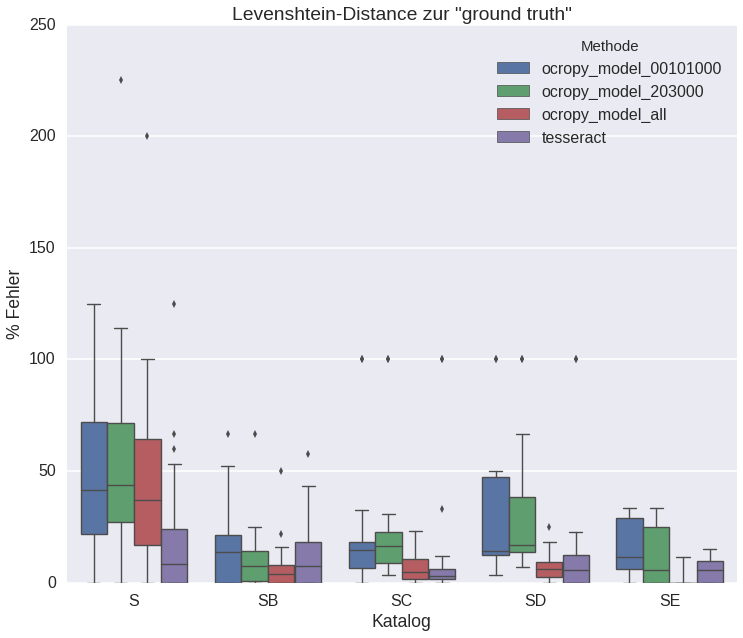

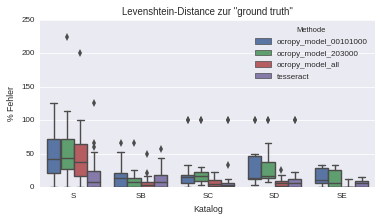

In [21]:
sns.set_context('poster')
fig = plt.figure(figsize=(12,10), dpi=300)
ax = sns.boxplot(x='Katalog', y='% Fehler', data=result_data, hue='Methode', linewidth=1.4)
ax.set_title('Levenshtein-Distance zur "ground truth"')
plt.savefig('../plots/gt_distance_poster.jpg', dpi=300)
plt.show()

sns.set_context('paper')
fig = plt.figure(figsize=(6,3), dpi=600)
ax = sns.boxplot(x='Katalog', y='% Fehler', data=result_data, hue='Methode')
ax.set_title('Levenshtein-Distance zur "ground truth"')
plt.savefig('../plots/gt_distance_paper.jpg', dpi=300)
plt.show()

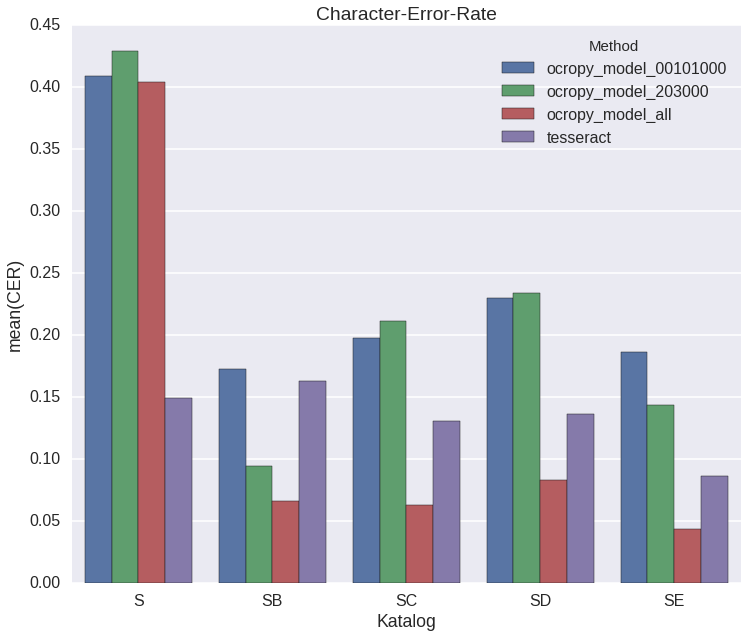

In [32]:
def get_cer(data):
    for method, group in data.groupby(by='Methode'):
        for key, group in group.groupby(by='Katalog'):
            yield {'Method': method, 'Katalog': key, 'CER': group['distance'].sum() * 1.0 / group['total'].sum()}

cer_data = pd.DataFrame(get_cer(result_data))

sns.set()
sns.set_context('poster')
fig = plt.figure(figsize=(12,10), dpi=300)
sns.barplot(x='Katalog', y='CER', hue='Method', data=cer_data)
plt.title('Character-Error-Rate')
plt.savefig('../plots/cer-rate.jpg', dpi=300)

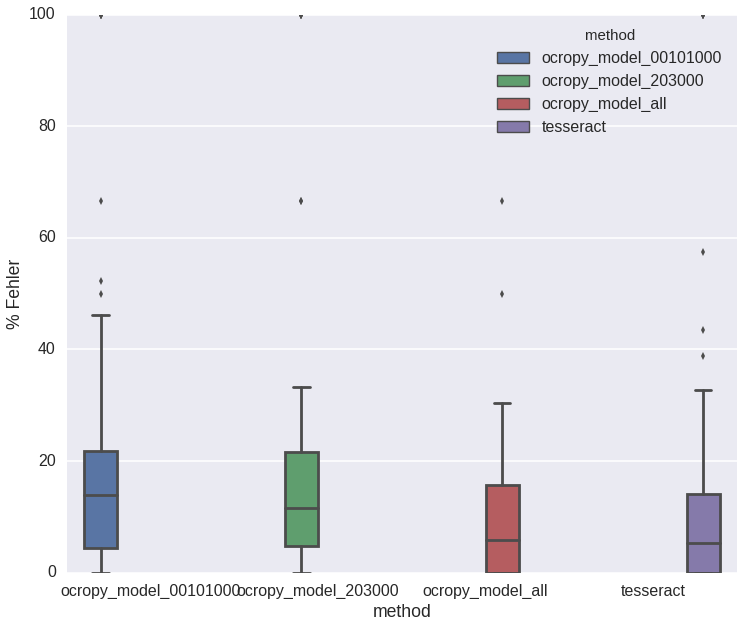

In [81]:
sns.set_context('poster')
fig = plt.figure(figsize=(12,10), dpi=300)
ax = sns.boxplot(width=0.8, x='method', y='% Fehler', data=data, hue='method')
plt.savefig('../plots/gt_distance_methods_paper.jpg', dpi=300)
plt.show()

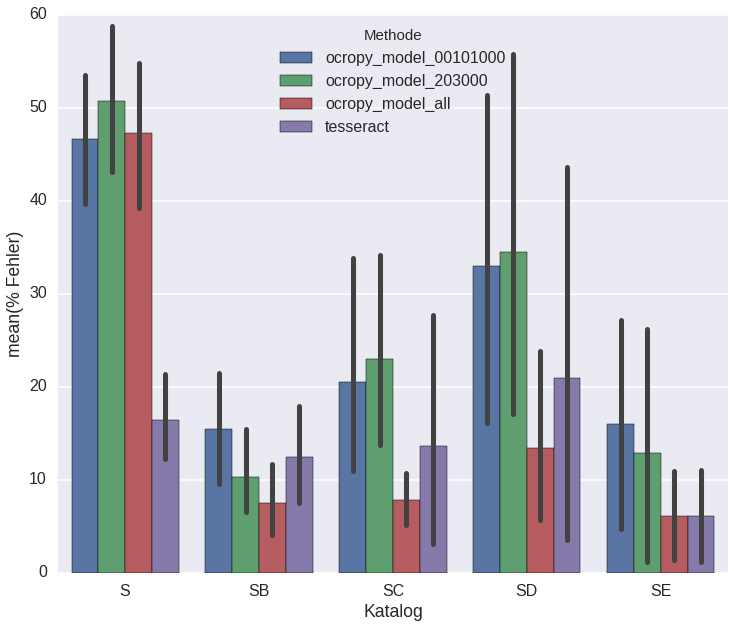

In [113]:
sns.set_context('poster')
fig = plt.figure(figsize=(12,10), dpi=300)
sns.barplot(x='Katalog', y='% Fehler', data=result_data, hue='Methode', capsize=1)
plt.savefig('../plots/gt_distance_paper_bars.jpg', dpi=300)
plt.title("")
plt.show()

In [28]:
model_names = {'ocropy_model_00101000': 'A',
 'ocropy_model_203000':'B',
 'ocropy_model_all':'C',
 'tesseract':'T'}
model_names.setdefault('unkown')
cer_data['Model'] = cer_data.apply(lambda row:model_names[row['Method']],axis=1)

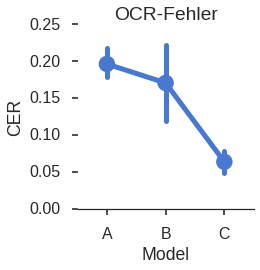

In [29]:
sns.set(style="ticks", palette="muted", color_codes=True)
sns.set_context('talk')
data = cer_data[cer_data.Method != 'tesseract']
data = data[data.Katalog != 'S']
sns.set_context('poster')
fig = plt.figure(figsize=(12,10), dpi=300)
ax = sns.factorplot(width=0.8, x='Model', y='CER', data=data, capsize=.2)

ax.despine(left=True)
plt.title('OCR-Fehler')
plt.savefig('../plots/gt_distance_ocropy.jpg', dpi=300)
plt.show()

In [150]:
set(result_data['Methode'])

{'ocropy_model_00101000',
 'ocropy_model_203000',
 'ocropy_model_all',
 'tesseract'}

In [154]:
result_data

,Katalog,Methode,gt,name,text,distance,total,% Fehler,Model
203,S,ocropy_model_00101000,St.,S361_00000515_010004,St.,0,3,0.000000,A
204,S,ocropy_model_00101000,1750 und sein Wirken in Cöthen 1717-1723. Führ...,S067_00000482_010004,i7youndseinilirkeninCüthen ;;t:4.lührerdurchd....,28,65,43.076923,A
205,S,ocropy_model_00101000,S.,S189_00000406_010001,s.,1,2,50.000000,A
206,S,ocropy_model_00101000,s.C o n r a d i: op.91.,S125_00000703_010004,s.Conraddi:op.91.,7,23,30.434783,A
207,S,ocropy_model_00101000,"u b e r , Dan. Franç.Espr.",S022_00000090_010001,".hf,l..F3.:;.'",23,27,85.185185,A
208,S,ocropy_model_00101000,Berlin: Bennefeld (1941). 146 S. 8°,S307_00000636_010005,lurlii:lßuiacicll(i0i).iu0S.S',25,35,71.428571,A
209,S,ocropy_model_00101000,"Haendel, Georg Friedrich: Der Feldherr",S249_00000059_010001,"Haendel, Georg Friedrich:il.Feldherr",5,38,13.157895,A
210,S,ocropy_model_00101000,M. 197,S265_00000001_010002,é,6,6,100.000000,A
211,S,ocropy_model_00101000,195,S377_00000446_010005,ib3,3,3,100.000000,A
212,S,ocropy_model_00101000,"i n g e r,",S176_00000752_010002,"in,ar.",7,10,70.000000,A
